## Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill
import librun
from libutil import out_dir
from dotenv import load_dotenv; load_dotenv()
from importlib import reload; import libplot; 
from sklearn import metrics
from tabulate import tabulate
import ipywidgets as widgets
from libplot import align_yaxis
import random
from matplotlib.colors import ListedColormap
import libregionplot
from mimic_alpha import colorAlpha_to_rgb as color_alpha

import warnings
warnings.filterwarnings("ignore")

In [4]:
from libdatasets import *; from libadversarial import uncertainty_stop; reload(librun)
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("rcv1-58509", wrap(rcv1, 58509)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "neural-network"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner, matrix, state: state.X_unlabelled.shape[0] < 510),
        "pool_subsample": 1000
    }
}
datasets = [d[0] for d in matrix['datasets']]
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=29, ret_classifiers=False)
results_plots = results

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-71c7d447-6acd-401b-8e87-9be7ceca60b4.json']
Current commit: 78f615b



Experiment:   0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
def read_stopping(name):
    file = f"{out_dir()}/stopping2/{name}__none__uncertainty__neural-network__dataset_size=1000__labelled_size=10__test_size=0.5__n_runs=10__ret_classifiers=True__ensure_y=True__stop_info=True__aggregate=False__stop_function=r__pool_subsample=1000.pickle"
    with open(file, "rb") as f:
        return dill.load(f)

In [6]:
# this is 10 runs on svm-linear, initial set size 10, no data modification
# None indicates a condition failed to stop
results = {}
for name in datasets:
    results[name] = read_stopping(name)

In [7]:
for _name, _conds in results.items():
    for _cname, _runs in _conds.items():
        if isinstance(_runs, dict):
            arr = [None]*(max(_runs.keys())+1)
            for i, v in _runs.items():
                arr[i] = v
            results[_name][_cname] = arr

In [8]:
dataset_order = ['sensorless', 'webkb', 'swarm', 'smartphone', 'splice', 'avila', 'anuran', 'spamassassin']

In [9]:
to_plot_min = ['Overall Uncertainty', 'Performance Convergence', 'Max Confidence', 'VM', 'SC_entropy_mcs', 'SC_oracle_acc', 'EVM', 'SSNCut', 'Stabilizing Predictions', 'Uncertainty Convergence', 'Classification Change', 'Contradictory Information']
results_filter_min_unordered = {dataset: {name: r for name, r in conds.items() if name in to_plot_min} for dataset, conds in results.items()}
results_filter_min = dict()
for k in dataset_order:
    results_filter_min[k] = results_filter_min_unordered[k]

In [10]:
# rename criteria to presentation names and reorder to match rel. work order
name_map = {
    'Max Confidence': 'Max confidence', #2007
    
    'SC_entropy_mcs': 'Entropy-MCS',
    'SC_oracle_acc': 'OracleAcc-MCS', #2008 jan
    
    'Classification Change': 'Classification change', # 2008 august
    'Overall Uncertainty': 'Overall uncertainty', # 2008  august
    
    'Uncertainty Convergence': 'Uncertainty convergence',
    'Performance Convergence': 'Performance convergence', # 2008 august
    
    'Contradictory Information': 'Contradictory information', # 2008 july
    
    'Stabilizing Predictions': 'Stabilizing predictions', # 2009
    
    'VM': 'VM',
    'EVM': 'EVM', # 2010
}

In [11]:
results_filter_new = dict()
for dataset, criterias in results_filter_min.items():
    results_filter_new[dataset] = dict()
    for old, new in name_map.items():
        results_filter_new[dataset][new] = results_filter_min[dataset][old]
results_filter_min = results_filter_new; del results_filter_new

### Colormap

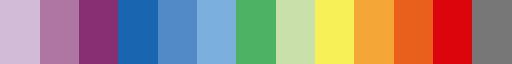

In [12]:
# colors = sns.color_palette('tab20', len(to_plot_min)).as_hex()
# random.seed(10); random.shuffle(colors)
all_colors = np.array(['#777777', '#E8ECFB', '#D9CCE3', '#D1BBD7', '#CAACCB', '#BA8DB4', '#AE76A3', '#AA6F9E', 
                       '#994F88', '#882E72', '#1965B0', '#437DBF', '#5289C7', '#6195CF', '#7BAFDE', '#4EB265', 
                       '#90C987', '#CAE0AB', '#F7F056', '#F7CB45', '#F6C141', '#F4A736', '#F1932D', '#EE8026', 
                       '#E8601C', '#E65518', '#DC050C', '#A5170E', '#72190E', '#42150A'])
colors = all_colors[[3,6,9,10,12,14,15,17,18,21,24,26,0]]
cmap = ListedColormap(colors, name='Z'); cmap

In [13]:
criteria_map = {name: color for name, color in zip(results_filter_min['webkb'].keys(), colors)}

In [14]:
mm = 1/2.54/10
fig_width = 174*mm
fig_max_height = 195*mm

## Full Range Pareto Plots

In [81]:
results_filter_min['smartphone']['Max confidence']

[StopResult(instances=22.0, accuracy_score=0.5871156661786238, f1_score=0.5871156661786238, roc_auc_score=0.8836951148806849, metric=array([3.65993465e-01, 5.23379879e-05, 8.60386459e-01, 5.56989552e-02,
        7.35784010e-01, 7.89986649e-01, 7.53622168e-01, 9.35767782e-01,
        5.33389915e-03, 7.05556116e-01, 7.05314735e-01, 5.84863625e-01,
        6.87906267e-01, 7.81160776e-01, 6.94515985e-01, 7.03625003e-01,
        6.99340399e-01, 7.22335001e-01, 7.35746143e-01, 1.21422821e+00,
        7.00979691e-01, 6.93538263e-01, 6.58621565e-01, 7.01155560e-01,
        7.00886810e-01, 6.88175040e-01, 7.03649959e-01, 6.59897967e-01,
        6.97508910e-01, 6.86497234e-01, 6.43736912e-01, 6.94107862e-01,
        6.92325270e-01, 6.71810072e-01, 6.30149931e-01, 6.98531597e-01,
        6.84713295e-01, 6.93041543e-01, 6.22953035e-01, 9.42264812e-01,
        6.83169927e-01, 6.59989639e-01, 6.84596463e-01, 6.73985709e-01,
        6.91430829e-01, 6.68137754e-01, 6.11233524e-01, 6.78207715e-01,
    

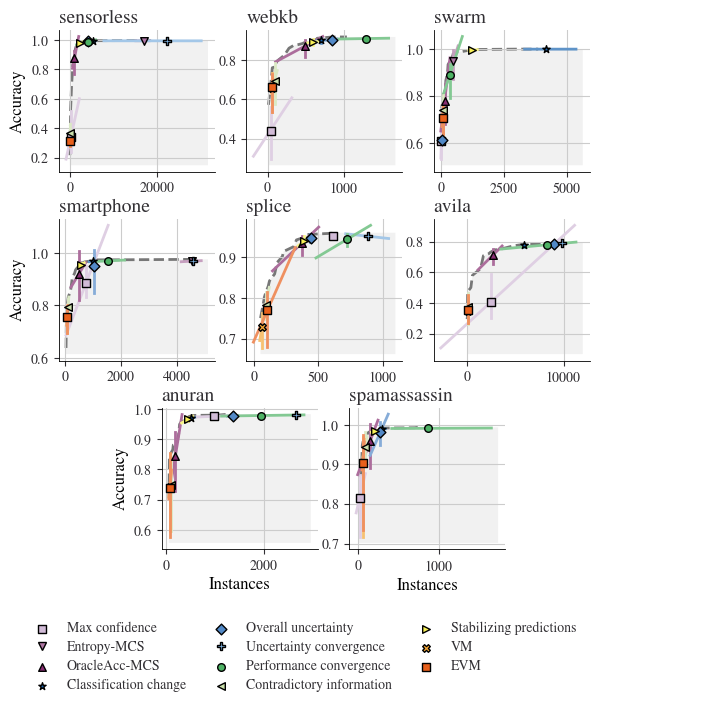

In [58]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    fig, ax = plot_paraeto_hull(
        results_filter_min, 
        rows=3, cols=3, 
        figsize=(fig_width,180*mm), 
        dpi=100, 
        hull=False, error='pca', 
        colors=criteria_map, 
        legend_loc='upper center', legend_cols=3, legend_bbox=(-1.5, -0.3)
    )
    ax.flatten()[-1].set_axis_off()
    #plt.delaxes(ax.flatten()[-1])
    for a in ax.flatten()[6:]:
        box = a.get_position()
        a.set_position([box.x0+0.15, box.y0, box.width, box.height])

plt.savefig('pdf/pareto_net.pdf', bbox_inches='tight')

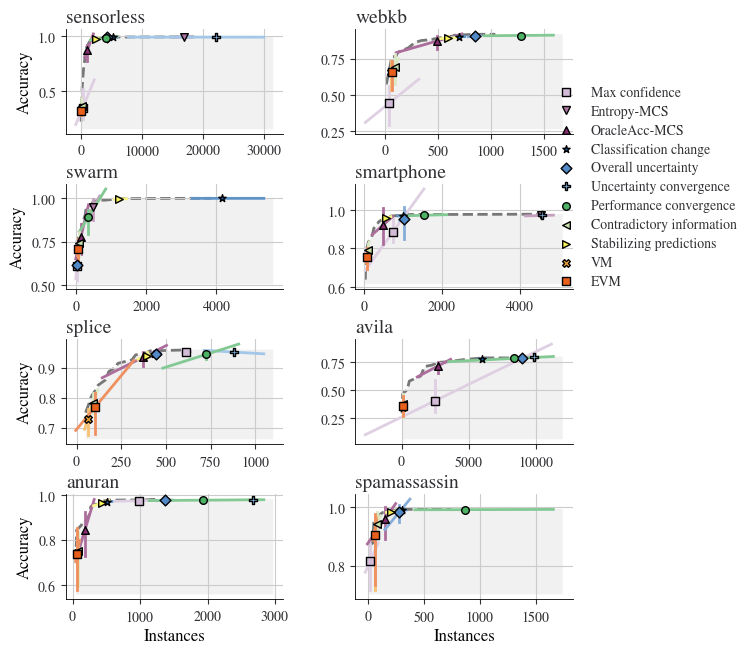

In [57]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    fig, axes = plot_paraeto_hull(
        results_filter_min, 
        rows=4, cols=2, 
        figsize=(fig_width,200*mm), 
        dpi=100, 
        hull=False, error='pca', 
        colors=criteria_map, 
        legend_loc='upper right', legend_cols=1, legend_bbox=(1.8, 5.)
    )
for ax in axes.flatten():
    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width*0.9, box.height*0.9])
plt.savefig('pdf/pareto_net.pdf', bbox_inches='tight')

Errors drawn asymmetrically using 2.5% and 97.5% percentiles.

### Optimal Regions (Ranking Formula)

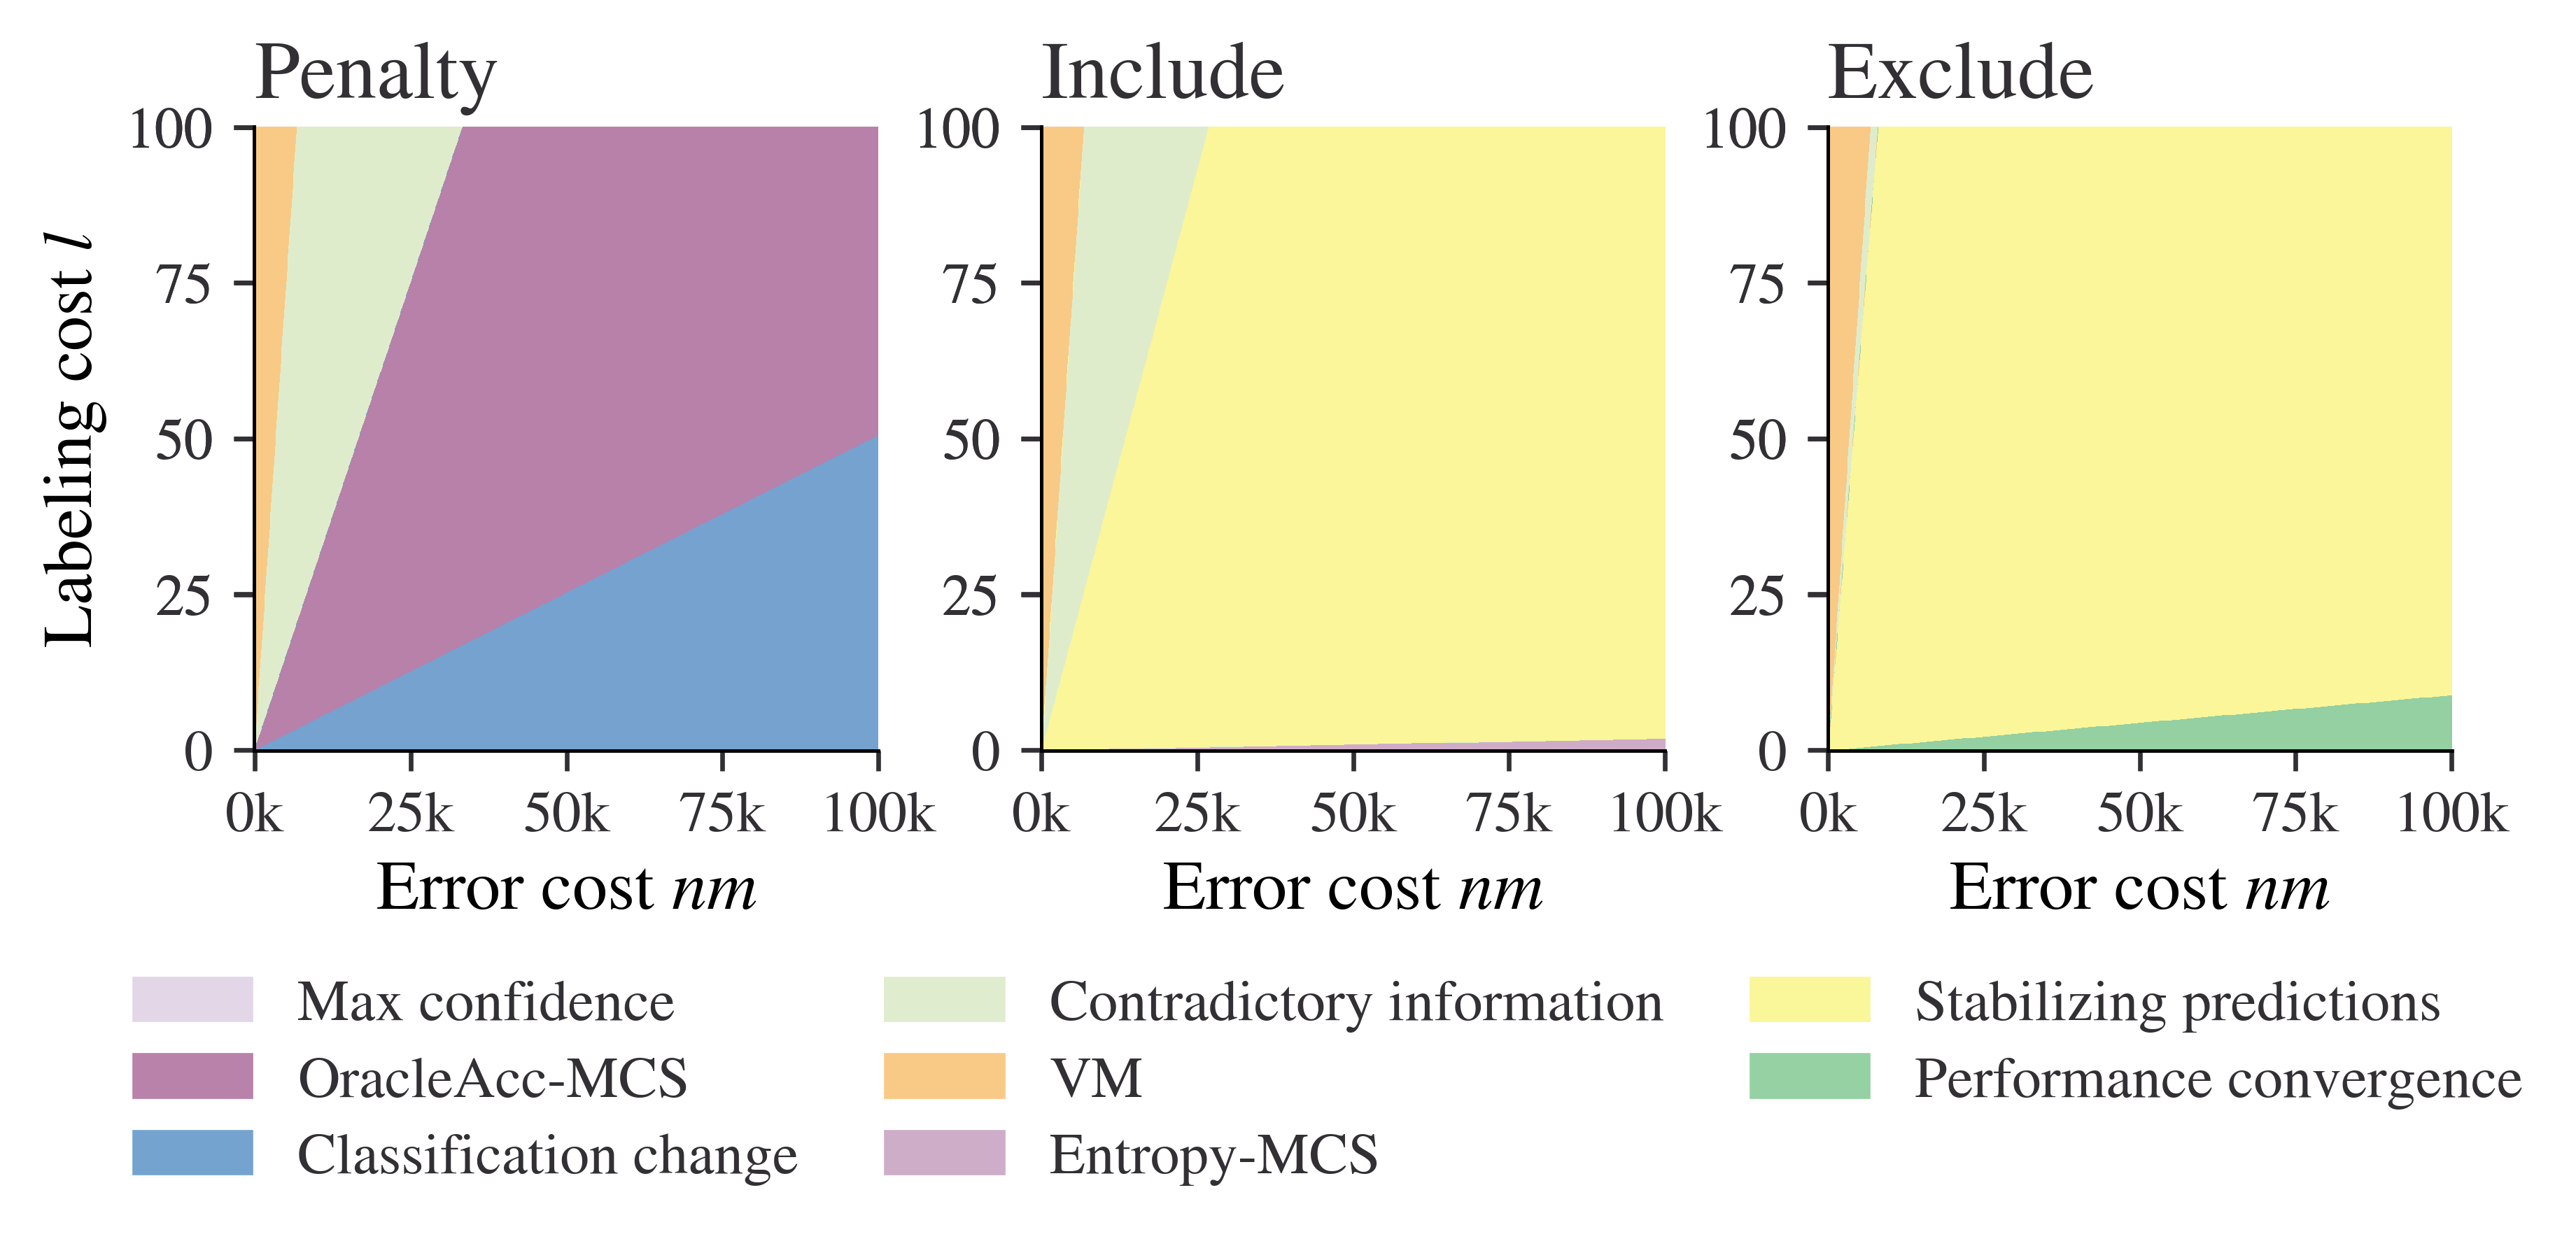

In [59]:
reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(fig_width, 50*mm), dpi=600)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter_min, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0, alpha=0.6)
    plt.legend(handles=patches, bbox_to_anchor=(-0.8, -0.3), loc="upper center", ncol=3, frameon=False)
#plt.tight_layout()
plt.savefig('pdf/cost_net.pdf', bbox_inches='tight')

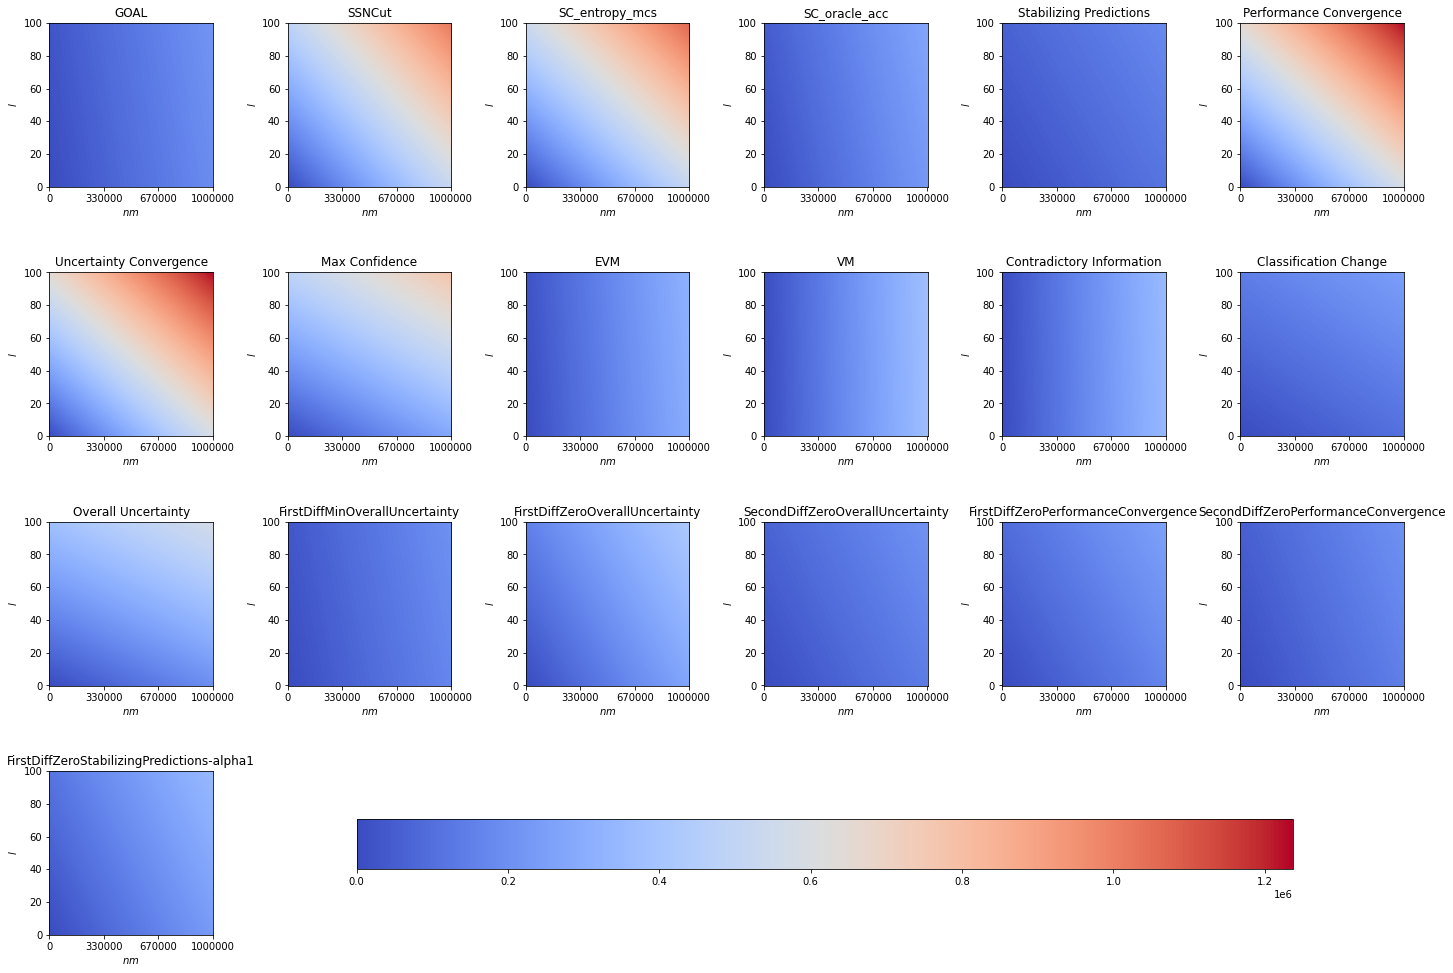

In [846]:
costs(results_filter)

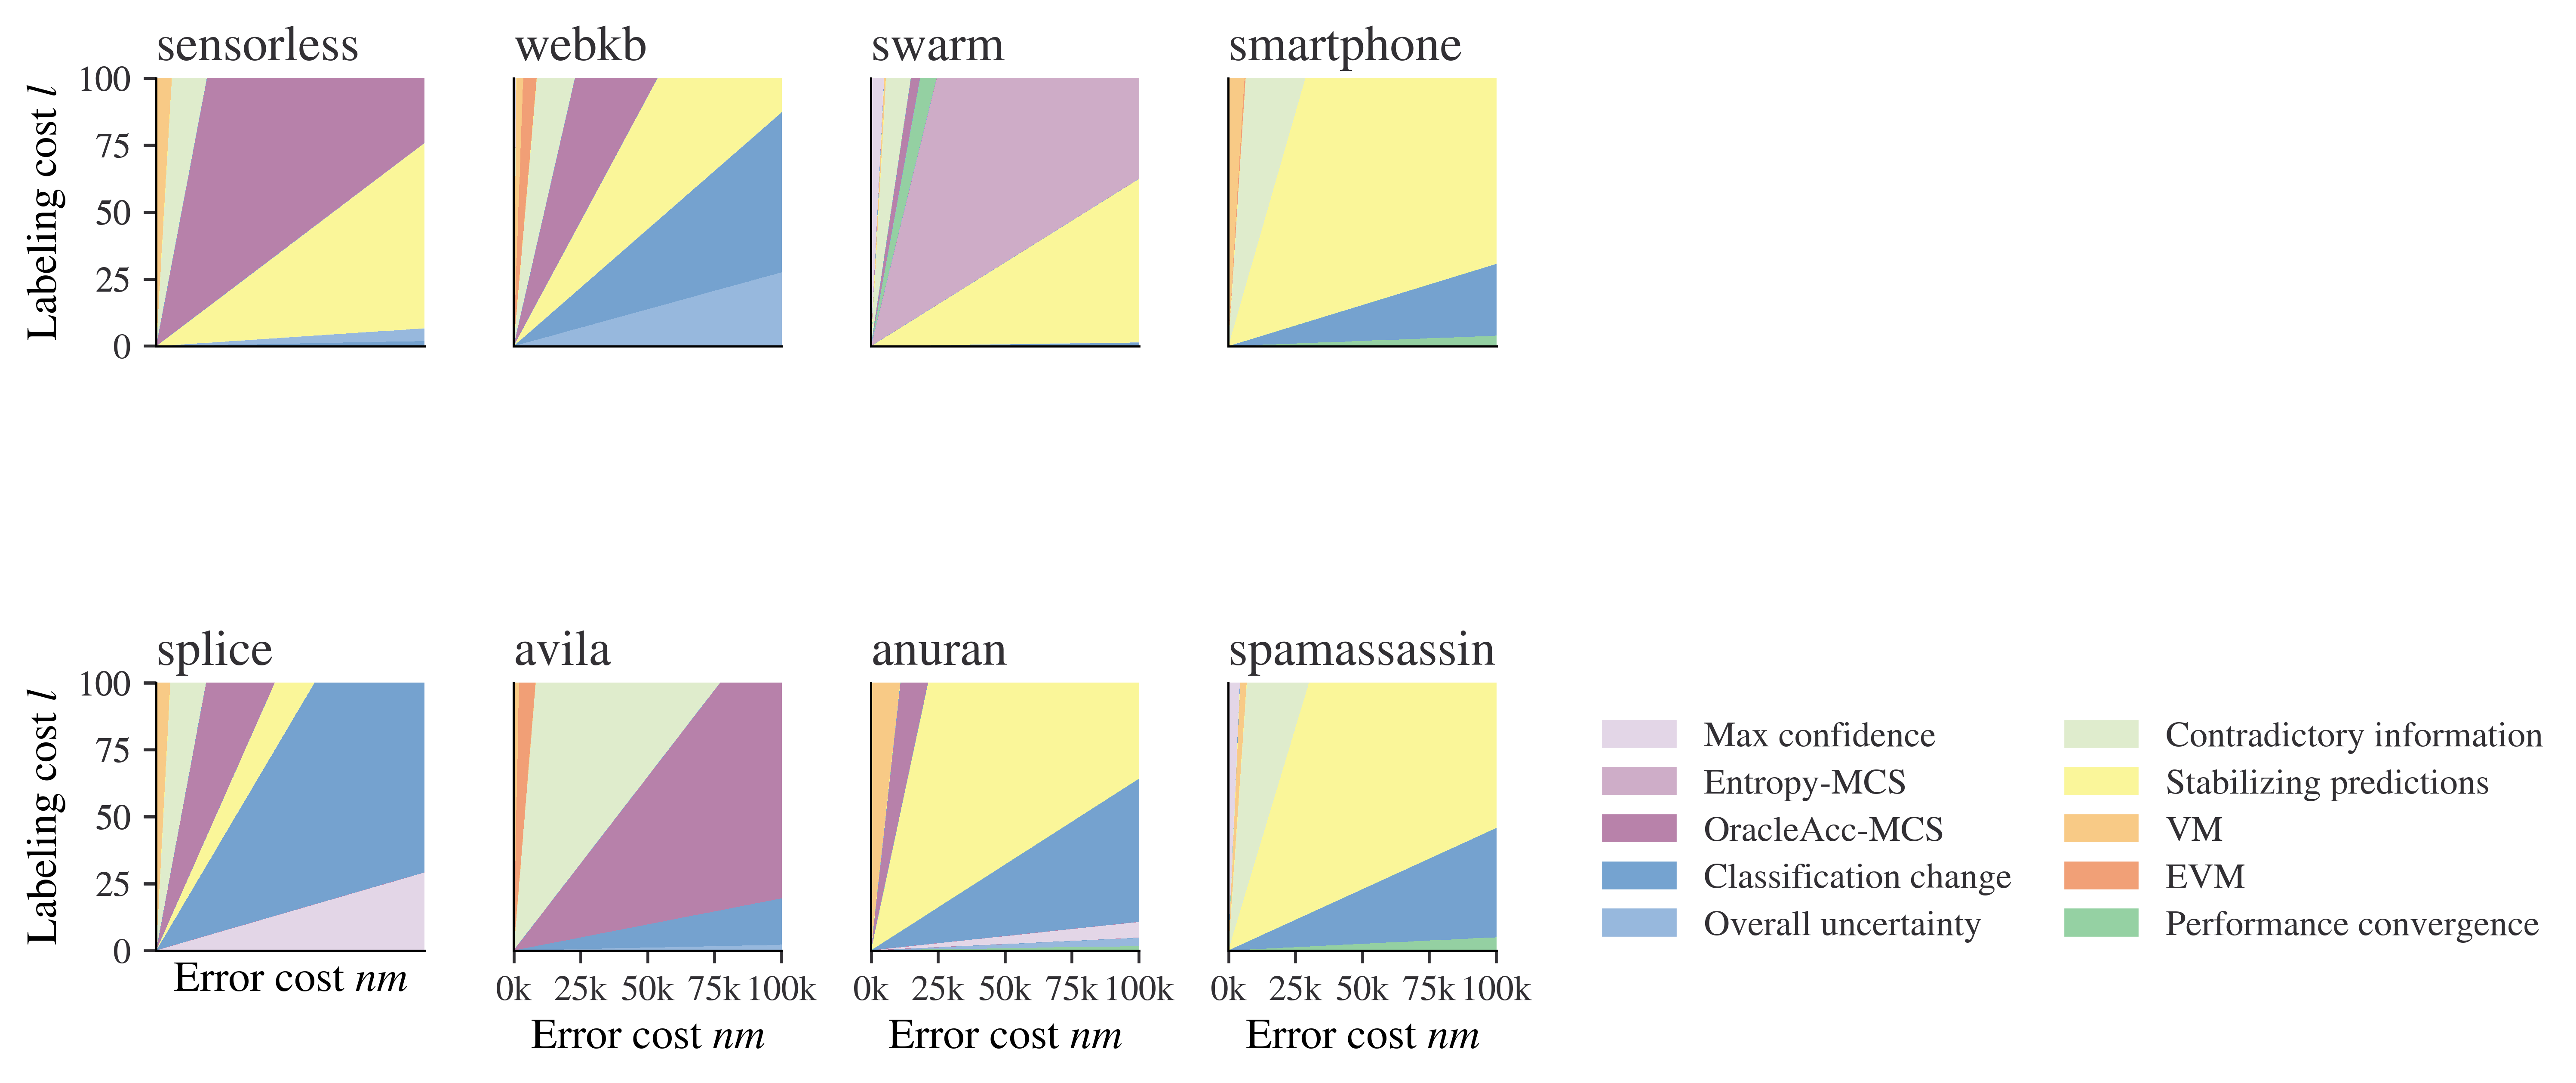

In [60]:
import libregionplot; reload(libregionplot); from libregionplot import regions, costs
import math
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(math.ceil(len(results_filter_min)/4), 4, figsize=(fig_width,6.3), dpi=600)
    patches = []
    for i, ((dataset, r), ax) in enumerate(zip(results_filter_min.items(), axes.flatten())):
        regions(
            {dataset: r}, 
            colors=criteria_map, 
            failed_to_stop="penalty", 
            title=dataset.rstrip("-58509"), 
            ax=ax, 
            patches=patches, 
            left=i%4==0, 
            bottom=i>len(results_filter_min)-5,
            alpha=0.6)
    # remove duplicate ticks (to avoid distractions)
    for i in [1,2,3,5,6,7]: # remove yticks
        axes.flatten()[i].tick_params(left=False, labelleft=False)
    for i in [0,1,2,3,4]: # remove xticks
        axes.flatten()[i].tick_params(bottom=False, labelbottom=False)
        
    for ax in axes.flatten()[len(results_filter_min):]:
        fig.delaxes(ax)
    for ax in axes.flatten():
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])
    for ax in axes.flatten()[4:]:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0+0.04, box.width, box.height])
    plt.legend(handles=patches, bbox_to_anchor=(5., 0.95), ncol=2, frameon=False)
    
    #plt.suptitle("Linear SVM (Penalty)")
plt.savefig('pdf/cost_datasets_net.pdf', bbox_inches='tight')

In [62]:
from autorank import autorank, plot_stats
import libregionplot; reload(libregionplot); from libregionplot import *
def new_autorank(n, m, l, compare_ranks=False, title='Autorank', height=3.8):
    C_rel_ex = np.vectorize(C_rel_nonvec, signature="(a,b),(a,b),(),()->(a,b)")
    conds, instances, accuracy = compute_criteria_arrays_autorank(results_filter_min)
    costs = C_rel_ex(accuracy, instances, n*m, l)
    df = pd.DataFrame(costs.T, columns=conds)
    rankresult = autorank(df, order="ascending")
    fig, ax = plt.subplots(1, 1, figsize=(fig_width, height))
    plot_stats(rankresult, ax=ax)
    if title is not None:
        ax.set_title(title)
    if compare_ranks:
        print("median:", df.median().sort_values().index)
        print("mean:", df.mean().sort_values().index)
        print("AUTORANK median:", rankresult.rankdf.sort_values('median').index)
        print("AUTORANK medianrank:", rankresult.rankdf.sort_values('meanrank').index)

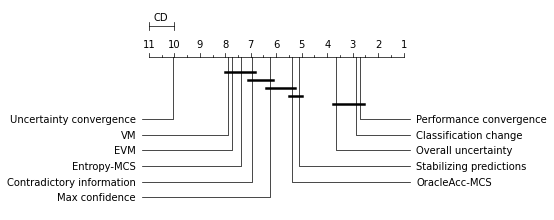

In [63]:
# Mammogram example
new_autorank(336000, 10742, 13.6, title=None)
plt.savefig('pdf/ex_mammogram_net.pdf', bbox_inches='tight')

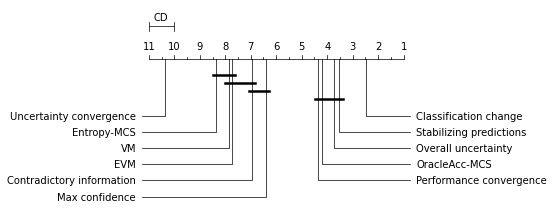

In [64]:
# Marketing example
new_autorank(2000, 20, 1, title=None)
plt.savefig('pdf/ex_marketing_net.pdf', bbox_inches='tight')

## Failed To Stop

In [65]:
table = []
for dataset, methods in results_filter_min.items():
    table.append([])
    for method, results in methods.items():
        table[-1].append(np.count_nonzero([result[0] for result in results]))

In [66]:
failed_to_stop = pd.DataFrame(table, [s.rstrip("-58509") for s in results_filter_min.keys()], list(results_filter_min['webkb'].keys()))

In [67]:
def failed_to_stop_plot(ax, failed_to_stop, color=None, alpha=0.6):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(7,6), dpi=125)
    with plt.style.context('plt_style.txt'):
        
        sns.heatmap(failed_to_stop.T, annot=True, ax=ax, cmap=sns.light_palette(color_alpha([color], alpha)[0], as_cmap=True, reverse=True));
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
#failed_to_stop_plot(None, failed_to_stop[failed_to_stop.sum().sort_values().index], color=cmap(11))

* **TODO: Remove criteria which only support SVMs**

In [68]:
from collections import defaultdict

In [79]:
accs = defaultdict(list)
mets = defaultdict(list)
for dataset, methods in results_filter_min.items():
    for method, runs in methods.items():
        
        for conf, rplots in results_plots:
            if conf.dataset_name == dataset:
                dataset_results = rplots
                break
            
        accuracies = []
        metrics = []
        for i, run in enumerate(runs):
            if run.metric is None:
                continue
            accuracies.append(dataset_results[i].accuracy_score)
            if isinstance(run.metric, tuple):
                metrics.append(run.metric[0])
            else:
                metrics.append(run.metric)
            if len(accuracies[-1]) != len(metrics[-1]):
                # TODO: Fix off by one in SC_oracle_acc
                if method == "Max confidence" or method == "OracleAcc-MCS":
                    metrics[-1] = [np.nan, *metrics[-1]]
                else:
                    print(dataset, method)
                    print(f"{len(accuracies[-1])} != {len(metrics[-1])}")
                    raise Exception()
        
        a = np.array(accuracies).flatten()
        m = np.array(metrics).flatten()
        
        # remove nan metric observations
        print(method, m.dtype); print(m)
        mask =~ np.isnan(m)
        m = m[mask]
        a = a[mask]
        
        accs[method].append(a)
        mets[method].append(m)

Max confidence float64
[5.75353948e-03 4.51949037e-01 4.44479358e-01 ... 6.13774181e-09
 9.16775076e-14            nan]
Entropy-MCS float64
[       nan 2.25082234 2.23859758 ... 0.00632273 0.01341817 0.00762452]
OracleAcc-MCS float64
[nan 0.2 0.2 ... 1.  1.  1. ]
Classification change float64
[       nan 0.66041802 0.6656743  ... 1.         1.         1.        ]
Overall uncertainty float64
[           nan 3.69796219e-01 4.13767225e-01 ... 6.43290673e-06
 1.70730817e-05 1.31235080e-05]
Uncertainty convergence float64
[0.59717364 0.75065608 0.74533073 ... 0.00183692 0.00095909        nan]
Performance convergence float64
[0.64037218 0.59109722 0.57818184 ... 0.99998293 0.99998688 0.99999001]
Contradictory information float64
[        nan  6.17865949  8.89559482 ...  9.88310674  5.06956395
 10.        ]
Stabilizing predictions float64
[       nan        nan 0.63116145 ... 1.         1.         1.        ]
VM float64
[           nan 3.41828921e-02 5.14156149e-02 ... 5.30200557e-08
 4.16237

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [168]:
correlations = {
    method: np.mean([scipy.stats.pearsonr(acc, met)[0] for acc, met in zip(accs[method], mets[method]) if len(acc) >= 2])
    for method in results_filter_min['spamassassin'].keys()
}
correlations_err = {
    method: scipy.stats.sem([scipy.stats.pearsonr(acc, met)[0] for acc, met in zip(accs[method], mets[method]) if len(acc) >= 2])
    for method in results_filter_min['spamassassin'].keys()
}

In [185]:
def plot_correlations(ax, k, v, yerr, abs_v=True, title="Correlations", labels=True, width=0.8, order=True, color=None, alpha=0.6):
    k, v, yerr = list(k), list(v), list(yerr)
    if abs_v:
        v = np.abs(v)
    if order:
        order = np.argsort(v)
        k = np.array(k)[order]
        v = np.array(v)[order]
    else:
        k = np.array(k)
        v = np.array(v)
    ax.barh(k, v, xerr=yerr, height=width, color=color_alpha([color], alpha)[0])
    ax.set_ylabel("Absolute Pearsons r value")
    if not labels:
        ax.set_yticks(())
    #ax.set_title(title)
    #plt.xticks(rotation=90)

In [170]:
correlations_frame = pd.DataFrame({
        'r': correlations.values(),
        'r_err': correlations_err.values()
    },
    index=correlations.keys()
)

(11.0, 0.0)
(-0.9400000000000001, 10.940000000000001)


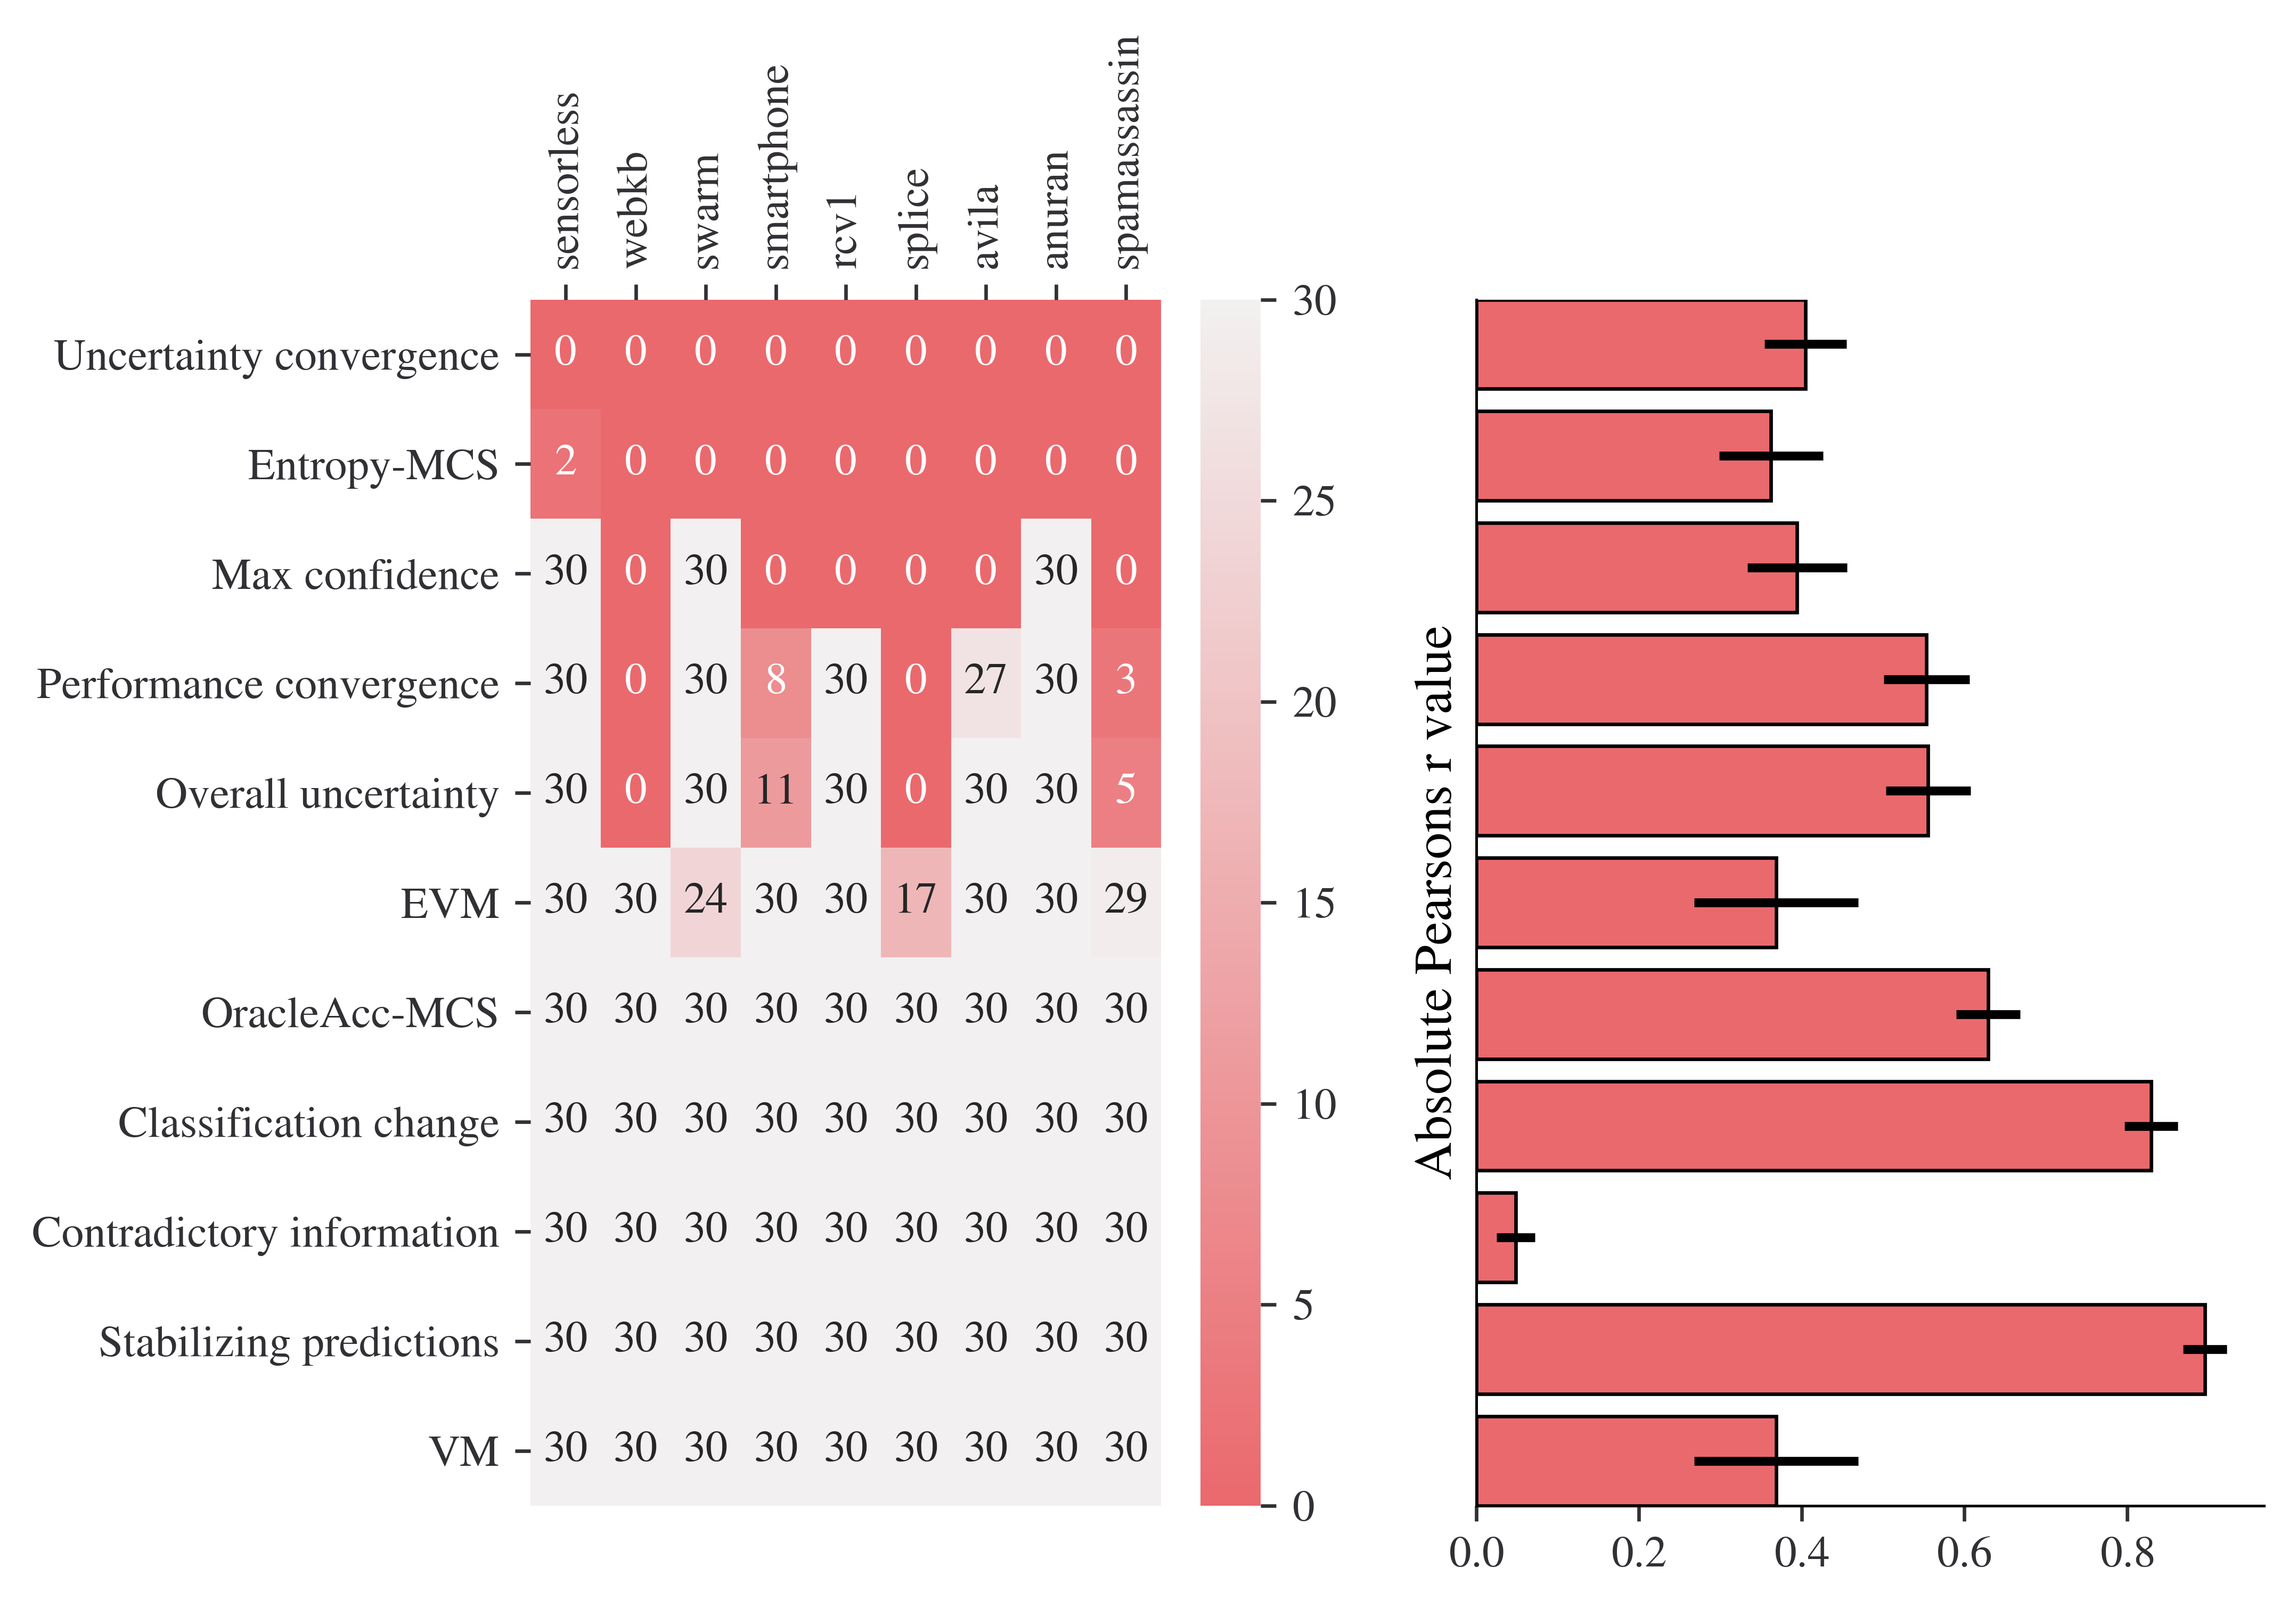

In [199]:
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1,2, figsize=(7,5), dpi=600)
    order = failed_to_stop.sum().sort_values().index
    cframe = correlations_frame.iloc[correlations_frame.index.get_indexer(order[::-1])]
    failed_to_stop_plot(axes[0], failed_to_stop[order], color=cmap(11), alpha=0.6)
    plot_correlations(
        axes[1], 
        cframe.index, 
        cframe.r, 
        cframe.r_err, 
        labels=False,
        order=False,
        color=cmap(11),
        alpha=0.6
    )
    
print(axes[0].get_ylim())
print(axes[1].get_ylim())
axes[1].set_ylim((-.4, 10.4))
plt.savefig('pdf/combined_forest.pdf', bbox_inches='tight')